In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/d_r_602_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1428_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1282_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_93_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/w_r_59_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1992_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1461_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/w_r_101_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/d_r_379_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/d_r_598_.jpg
/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST/images/f_r_1303_.jpg
/kaggle/input/semantic-segmen

In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.layers import *


In [19]:
color_map = {
    (0, 0, 0): 0,        # BW
    (0, 0, 255): 1,      # HD 
    (0, 255, 0): 2,      # PF 
    (255, 255, 0): 3,    # WR 
    (0, 0, 128): 4,      # RO 
    (255, 0, 255): 5,    # RI 
    (0, 255, 255): 6,    # FV 
    (255, 255, 255): 7   # SR
}

In [20]:
index_to_color = {
    0: (0, 0, 0),
    1: (0, 0, 255),
    2: (0, 255, 0),
    3: (255, 255, 0),
    4: (0, 0, 128),
    5: (255, 0, 255),
    6: (0, 255, 255),
    7: (255, 255, 255)
}

In [21]:
def load_data(image_dir, mask_dir, image_size=(256, 256)):
    image_paths = []
    mask_paths = []
    
    for filename in os.listdir(os.path.join(image_dir, "images")):
        if filename.endswith(".jpg"):
            base_name = os.path.splitext(filename)[0]
            img_path = os.path.join(image_dir, "images", filename)
            mask_path = os.path.join(mask_dir, "masks", base_name + ".bmp")
            
            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)
    
    return image_paths, mask_paths


def get_augmentation():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.0625,
            scale_limit=0.1,
            rotate_limit=25,
            interpolation=cv2.INTER_LINEAR,
            mask_interpolation=cv2.INTER_NEAREST,
            p=0.5
        ),
        A.GridDistortion(
            num_steps=5,
            distort_limit=0.3,
            interpolation=cv2.INTER_LINEAR,
            mask_interpolation=cv2.INTER_NEAREST,
            p=0.2
        ),
        A.RandomBrightnessContrast(
            brightness_limit=0.2,
            contrast_limit=0.2,
            p=0.3
        )
    ], additional_targets={'mask': 'image'})

def data_generator(image_paths, mask_paths, batch_size=8, image_size=(256, 256)):
    aug = get_augmentation()
    while True:
        indices = np.random.permutation(len(image_paths))
        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_images = []
            batch_masks = []
            
            for j in batch_indices:
                img = cv2.imread(image_paths[j])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR转RGB
                img = cv2.resize(img, image_size)
                img = img.astype(np.float32) / 255.0
                
                mask = cv2.imread(mask_paths[j])
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # BGR转RGB
                mask = cv2.resize(mask, image_size, interpolation=cv2.INTER_NEAREST)

                augmented = aug(image=img, mask=mask)
                img_aug = augmented['image']
                mask_aug = augmented['mask']
                
                class_mask = np.zeros(mask_aug.shape[:2], dtype=np.uint8)
                for color, idx in color_map.items():
                    class_mask[np.all(mask_aug == color, axis=-1)] = idx
                
                batch_images.append(img_aug)
                batch_masks.append(class_mask)
            
            yield np.array(batch_images), np.array(batch_masks)


In [22]:
def rgb_to_class(mask_rgb, color_map):
    h, w, _ = mask_rgb.shape
    mask_flat = mask_rgb.reshape(-1, 3)
    class_mask = np.zeros((h*w,), dtype=np.uint8)
    
    color_arr = np.array(list(color_map.keys()))
    for i, pixel in enumerate(mask_flat):
        dist = np.sum((color_arr - pixel) ** 2, axis=1)
        class_mask[i] = list(color_map.values())[np.argmin(dist)]
    return class_mask.reshape(h, w)

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Conv2D, UpSampling2D, Dropout, concatenate, Resizing
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Reshape, Multiply, Add

from tensorflow.keras.metrics import SparseCategoricalAccuracy
import tensorflow as tf

def mean_iou_metric(y_true, y_pred):
    num_classes = 8
    y_pred = tf.argmax(y_pred, axis=-1)
    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, tf.int32)
    y_pred = tf.cast(y_pred, tf.int32)
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    # Compute confusion matrix
    cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_classes)
    sum_over_row = tf.reduce_sum(cm, axis=0)
    sum_over_col = tf.reduce_sum(cm, axis=1)
    diag = tf.cast(tf.linalg.tensor_diag_part(cm), tf.float32)
    denominator = tf.cast(sum_over_row + sum_over_col, tf.float32) - diag
    iou = diag / (denominator + tf.keras.backend.epsilon())
    miou = tf.reduce_mean(iou)
    return miou

def cbam_block(feature_map, ratio=8):
    # Channel Attention
    channel_avg = GlobalAveragePooling2D()(feature_map)
    channel_max = GlobalMaxPooling2D()(feature_map)
    shared_dense_one = Dense(feature_map.shape[-1] // ratio, activation='relu')
    shared_dense_two = Dense(feature_map.shape[-1], activation='sigmoid')
    channel = Add()([
        shared_dense_one(channel_avg),
        shared_dense_one(channel_max)
    ])
    channel = shared_dense_two(channel)
    channel = Reshape((1, 1, feature_map.shape[-1]))(channel)
    channel_mul = Multiply()([feature_map, channel])
    # Spatial Attention
    spatial = Conv2D(1, (7, 7), padding='same', activation='sigmoid')(channel_mul)
    cbam_feature = Multiply()([channel_mul, spatial])
    return cbam_feature

def UNetEfficientNetCBAM(input_size=(320, 320, 3), no_of_class=8):
    base_model = EfficientNetB0(input_shape=input_size, include_top=False, weights='imagenet')
    skips = [
        base_model.get_layer("block2a_expand_activation").output,
        base_model.get_layer("block3a_expand_activation").output,
        base_model.get_layer("block4a_expand_activation").output,
        base_model.get_layer("block6a_expand_activation").output,
    ]
    skips = [cbam_block(s) for s in skips]
    encoder_output = base_model.output

    x = encoder_output

    # Decoder block 1
    x = UpSampling2D((2, 2))(x)
    skips3_resized = Resizing(x.shape[1], x.shape[2])(skips[3])
    x = concatenate([x, skips3_resized])
    x = Conv2D(256, 3, activation='relu', padding='same')(x)
    x = Conv2D(256, 3, activation='relu', padding='same')(x)

    # Decoder block 2
    x = UpSampling2D((2, 2))(x)
    skips2_resized = Resizing(x.shape[1], x.shape[2])(skips[2])
    x = concatenate([x, skips2_resized])
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)

    # Decoder block 3
    x = UpSampling2D((2, 2))(x)
    skips1_resized = Resizing(x.shape[1], x.shape[2])(skips[1])
    x = concatenate([x, skips1_resized])
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)

    # Decoder block 4
    x = UpSampling2D((2, 2))(x)
    skips0_resized = Resizing(x.shape[1], x.shape[2])(skips[0])
    x = concatenate([x, skips0_resized])
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Dropout(0.5)(x)

    # Final upsampling to restore input size
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Conv2D(32, 3, activation='relu', padding='same')(x)
    x = Resizing(input_size[0], input_size[1])(x)
    outputs = Conv2D(no_of_class, 1, activation='softmax')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',  # masks: (batch, H, W, 1) integer labels 0..7
        metrics=[SparseCategoricalAccuracy(name='accuracy'), mean_iou_metric]
    )
    model.summary()
    return model

In [24]:
IMAGE_SIZE = IMAGE_SIZE = (256,256)
BATCH_SIZE = 8
EPOCHS = 100


train_image_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val"
train_mask_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/train_val"
test_image_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST"
test_mask_dir = "/kaggle/input/semantic-segmentation-of-underwater-imagery-suim/TEST"

train_image_paths, train_mask_paths = load_data(train_image_dir, train_mask_dir)
test_image_paths, test_mask_paths = load_data(test_image_dir, test_mask_dir)

train_img, val_img, train_msk, val_msk = train_test_split(
    train_image_paths, train_mask_paths, test_size=0.2, random_state=42)


In [25]:
def sparse_combined_loss(y_true, y_pred, alpha=0.5, num_classes=8):
    ce_loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    
    y_true_oh = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    y_pred_oh = tf.nn.softmax(y_pred)
    
    intersection = tf.reduce_sum(y_true_oh * y_pred_oh, axis=[1,2])
    union = tf.reduce_sum(y_true_oh + y_pred_oh, axis=[1,2])
    dice_loss = 1 - tf.reduce_mean((2. * intersection + 1e-7)/(union + 1e-7))
    
    gamma = 2.0
    focal_loss = tf.reduce_mean(-(1-y_pred_oh)**gamma * tf.math.log(y_pred_oh + 1e-7))
    
    return alpha*ce_loss + (0.5-alpha)*dice_loss + 0.2*focal_loss

In [26]:
def calculate_metrics(true_mask, pred_mask, num_classes):

    dice = np.zeros(num_classes)
    iou = np.zeros(num_classes)
    f1 = np.zeros(num_classes)
    
    for cls in range(num_classes):
        true_cls = (true_mask == cls)
        pred_cls = (pred_mask == cls)
        
        intersection = np.logical_and(true_cls, pred_cls).sum()
        union = np.logical_or(true_cls, pred_cls).sum()
        true_sum = true_cls.sum()
        pred_sum = pred_cls.sum()
        
        dice[cls] = (2. * intersection) / (true_sum + pred_sum + 1e-7)
        
        # IoU
        iou[cls] = intersection / (union + 1e-7)
        
        # F1
        precision = intersection / (pred_sum + 1e-7)
        recall = intersection / (true_sum + 1e-7)
        f1[cls] = 2 * (precision * recall) / (precision + recall + 1e-7)
    
    return dice, iou, f1


In [27]:
def visualize_results(image_path, mask_path, model, size=(256,256)):
    # 1.（BGR→RGB）
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    orig_size = img.shape[:2]
    img = cv2.resize(img, size)
    img_input = img.astype(np.float32)/255.0
    img_input = np.expand_dims(img_input, axis=0)
    
    # 2. predict
    pred = model.predict(img_input)[0]
    pred_mask = np.argmax(pred, axis=-1)
    
    # 3. mask（BGR→RGB）
    true_mask = cv2.imread(mask_path)
    true_mask = cv2.cvtColor(true_mask, cv2.COLOR_BGR2RGB)  
    true_mask = cv2.resize(true_mask, size, interpolation=cv2.INTER_NEAREST)
    
    true_class = np.zeros(true_mask.shape[:2], dtype=np.uint8)
    for color, idx in color_map.items(): 
        true_class[np.all(true_mask == color, axis=-1)] = idx
    
    
    pred_color = np.zeros((*size, 3), dtype=np.uint8)
    true_color = np.zeros((*size, 3), dtype=np.uint8)
    
    for idx, color in index_to_color.items():  
        pred_color[pred_mask == idx] = color
        true_color[true_class == idx] = color
    
   
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img) 
    plt.title("Original Image")
    
    plt.subplot(1,3,2)
    plt.imshow(true_color)
    plt.title("True Mask")
    
    plt.subplot(1,3,3)
    plt.imshow(pred_color)
    plt.title("Predicted Mask")
    plt.show()

In [28]:
train_gen = data_generator(train_img, train_msk, BATCH_SIZE, IMAGE_SIZE)
val_gen = data_generator(val_img, val_msk, BATCH_SIZE, IMAGE_SIZE)


model = UNetEfficientNetCBAM(input_size=IMAGE_SIZE + (3,))

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=sparse_combined_loss,
             metrics=['accuracy']
             )
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 256, 256,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 256, 256,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 10,316,735 (39.36 MB)

 Trainable params: 10,274,712 (39.19 MB)

 Non-trainable params: 42,023 (164.16 KB)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 256, 256,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 256, 256,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 257, 257,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 128, 128,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 128, 128,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 128, 128,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 128, 128,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │        512 │ block1a_se_excit

 Total params: 10,316,735 (39.36 MB)

 Trainable params: 10,274,712 (39.19 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [29]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_img) // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=len(val_img)//BATCH_SIZE,
    epochs=EPOCHS
)

val_dice = []
val_iou = []
val_f1 = []

for i in range(len(val_img)//BATCH_SIZE):
    x_val, y_val = next(val_gen)
    y_pred = model.predict(x_val)
    y_pred = np.argmax(y_pred, axis=-1)
    
    for j in range(len(y_val)):
        true_mask = y_val[j]
        pred_mask = y_pred[j]
        dice, iou, f1 = calculate_metrics(true_mask, pred_mask, num_classes=len(index_to_color))
        val_dice.append(dice)
        val_iou.append(iou)
        val_f1.append(f1)

avg_val_dice = np.mean(val_dice, axis=0)
avg_val_iou = np.mean(val_iou, axis=0)
avg_val_f1 = np.mean(val_f1, axis=0)

class_names = list(index_to_color.keys())
for cls, name in enumerate(class_names):
    print(f"Class {name}:")
    print(f"  Dice: {avg_val_dice[cls]:.4f}")
    print(f"  IoU: {avg_val_iou[cls]:.4f}")
    print(f"  F1: {avg_val_f1[cls]:.4f}")
    print()

mIoU = np.mean(avg_val_iou)
avg_dice = np.mean(avg_val_dice)
print(f"mIoU: {mIoU:.4f}")
print(f"Average Dice: {avg_dice:.4f}")


Epoch 1/100


W0000 00:00:1762858697.045299     552 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1762858703.854988     552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762858704.001100     552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762858712.133621     552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762858712.269264     552 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight System

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.4093 - loss: 1.1745

W0000 00:00:1762858785.920855     551 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


152/152 ━━━━━━━━━━━━━━━━━━━━ 170s 394ms/step - accuracy: 0.4099 - loss: 1.1737 - val_accuracy: 0.4811 - val_loss: 1.2769
Epoch 2/100


W0000 00:00:1762858804.693760     550 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1762858810.582039     550 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762858810.720353     550 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762858817.840745     550 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762858817.974975     550 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight System

152/152 ━━━━━━━━━━━━━━━━━━━━ 88s 292ms/step - accuracy: 0.6013 - loss: 0.9163 - val_accuracy: 0.4873 - val_loss: 1.0510
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 44s 289ms/step - accuracy: 0.6341 - loss: 0.8434 - val_accuracy: 0.4753 - val_loss: 1.1659
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.6478 - loss: 0.8152

W0000 00:00:1762858969.819310     553 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_combined_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
E0000 00:00:1762858970.366631     553 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762858970.497953     553 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


152/152 ━━━━━━━━━━━━━━━━━━━━ 50s 331ms/step - accuracy: 0.6478 - loss: 0.8151 - val_accuracy: 0.5210 - val_loss: 1.0351
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 42s 277ms/step - accuracy: 0.6705 - loss: 0.7899 - val_accuracy: 0.5462 - val_loss: 0.9941
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 39s 258ms/step - accuracy: 0.6788 - loss: 0.7679 - val_accuracy: 0.5634 - val_loss: 1.1289
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 251ms/step - accuracy: 0.6937 - loss: 0.7616 - val_accuracy: 0.6256 - val_loss: 0.9888
Epoch 8/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 252ms/step - accuracy: 0.7153 - loss: 0.7254 - val_accuracy: 0.6676 - val_loss: 0.8411
Epoch 9/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 252ms/step - accuracy: 0.7271 - loss: 0.7233 - val_accuracy: 0.6013 - val_loss: 0.9123
Epoch 10/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.7264 - loss: 0.7181 - val_accuracy: 0.4838 - val_loss: 1.6676
Epoch 11/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 38s 253ms/step - accuracy: 0.7247 - loss: 0.7

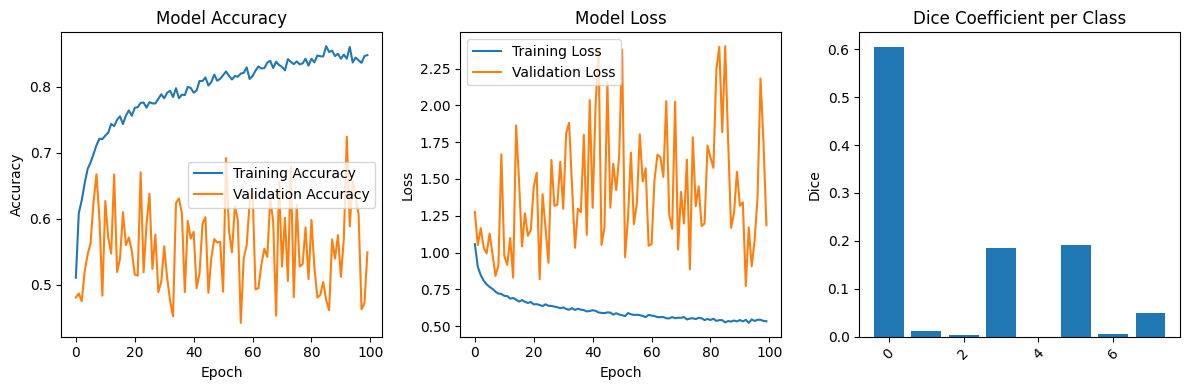

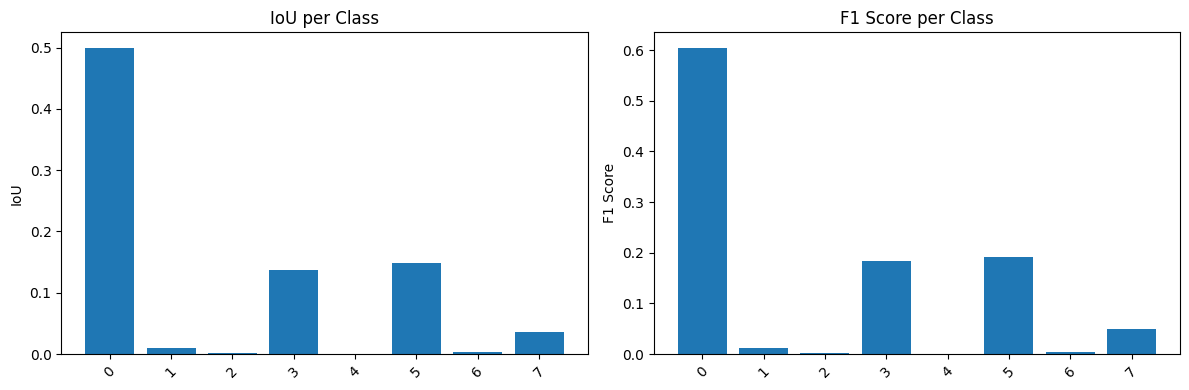

In [30]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


plt.subplot(1, 3, 3)
plt.bar(class_names, avg_val_dice)
plt.title('Dice Coefficient per Class')
plt.ylabel('Dice')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 4))

# IoU
plt.subplot(1, 2, 1)
plt.bar(class_names, avg_val_iou)
plt.title('IoU per Class')
plt.ylabel('IoU')
plt.xticks(rotation=45)

# F1
plt.subplot(1, 2, 2)
plt.bar(class_names, avg_val_f1)
plt.title('F1 Score per Class')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


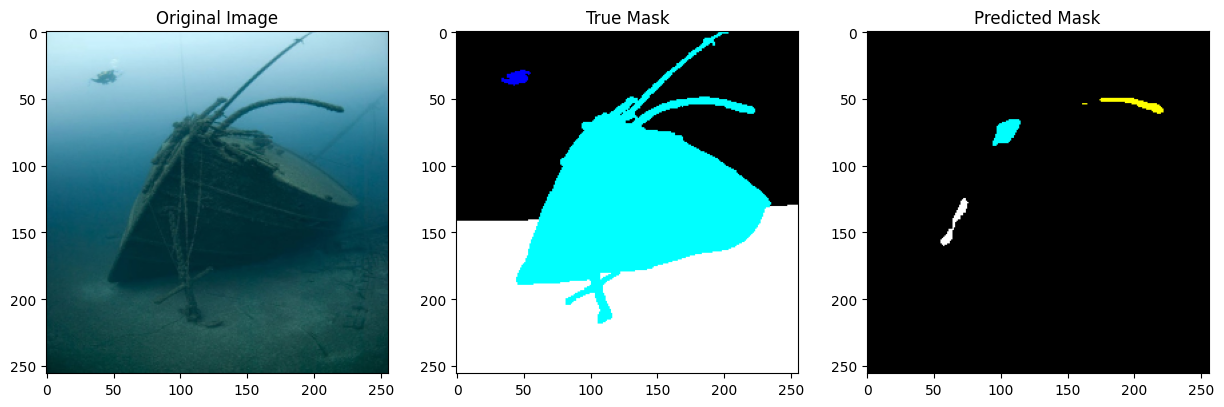

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


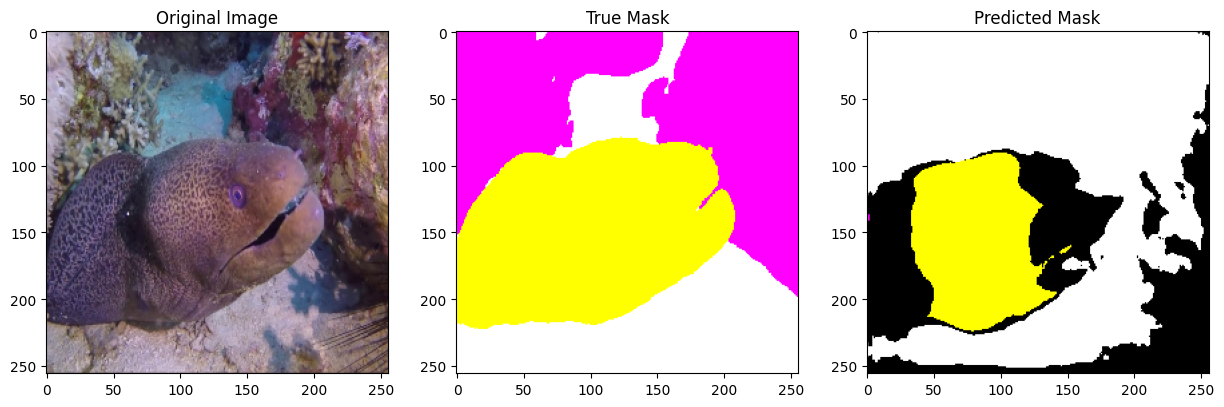

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


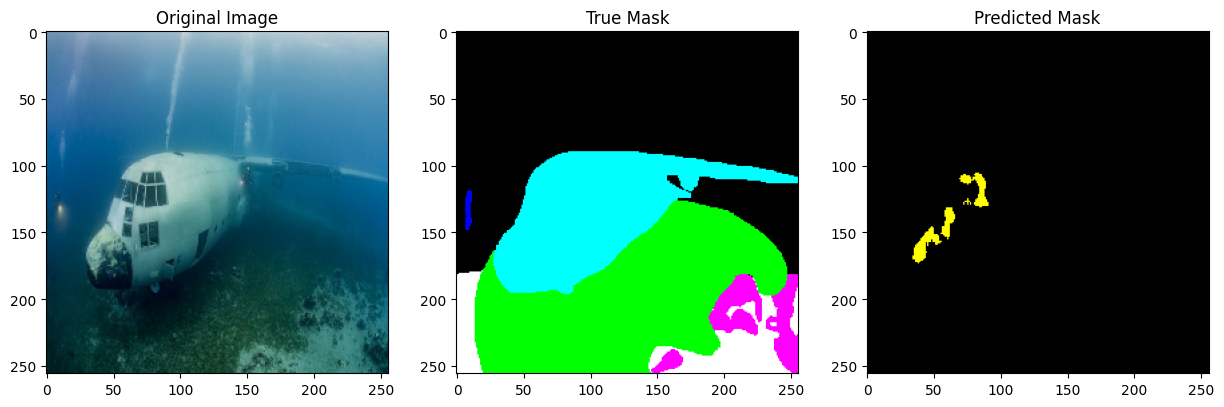

In [31]:
for i in np.random.choice(len(test_image_paths), 3):
    visualize_results(test_image_paths[i], test_mask_paths[i], model)